In [34]:
import numpy as np
import duckdb
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sfm
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats


## Research Question: 


### Where on the ice do teams typically execute their zone entries (e.g., near the blue line, along the boards)?

In [2]:
df = pd.read_csv('BDC_2024_Womens_Data.csv')
df.columns
df

##There are multiple games. 

,Date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,...,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2
0,2023-11-08,Women - United States,Women - Canada,1,20:00,5,5,0,0,Women - Canada,...,Faceoff Win,100,42,Backhand,NaN,NaN,NaN,Taylor Heise,NaN,NaN
1,2023-11-08,Women - United States,Women - Canada,1,19:57,5,5,0,0,Women - Canada,...,Puck Recovery,50,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-11-08,Women - United States,Women - Canada,1,19:54,5,5,0,0,Women - Canada,...,Play,3,59,Indirect,NaN,NaN,NaN,Renata Fast,4.0,35.0
3,2023-11-08,Women - United States,Women - Canada,1,19:52,5,5,0,0,Women - Canada,...,Play,6,21,Direct,NaN,NaN,NaN,Emma Maltais,48.0,2.0
4,2023-11-08,Women - United States,Women - Canada,1,19:50,5,5,0,0,Women - Canada,...,Incomplete Play,48,2,Direct,NaN,NaN,NaN,Marie-Philip Poulin,62.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7454,2023-12-16,Women - Canada,Women - United States,4,0:12,3,3,2,2,Women - Canada,...,Puck Recovery,164,82,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7455,2023-12-16,Women - Canada,Women - United States,4,0:09,3,3,2,2,Women - Canada,...,Shot,186,47,Snapshot,On Net,f,f,NaN,NaN,NaN
7456,2023-12-16,Women - Canada,Women - United States,4,0:06,3,3,2,2,Women - United States,...,Puck Recovery,22,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7457,2023-12-16,Women - Canada,Women - United States,4,0:03,3,3,2,2,Women - United States,...,Play,18,32,Direct,NaN,NaN,NaN,Hilary Knight,129.0,63.0


In [3]:
#Separating the data by each game.
df['Date'].unique()


array(['2023-11-08', '2023-11-11', '2023-12-14', '2023-12-16'],
      dtype=object)

In [15]:
#First we need to filter the data, so we get all the data focused on the zone entries and separate the data based 
#on whether they were dumped or carried

zone_entries = df[df['Event'] == 'Zone Entry']
dumped_entries = zone_entries[zone_entries['Detail 1'] == 'Dumped']
carried_entries = zone_entries[zone_entries['Detail 1'] == 'Carried']
played_entries = zone_entries[zone_entries['Detail 1'] == 'Played']

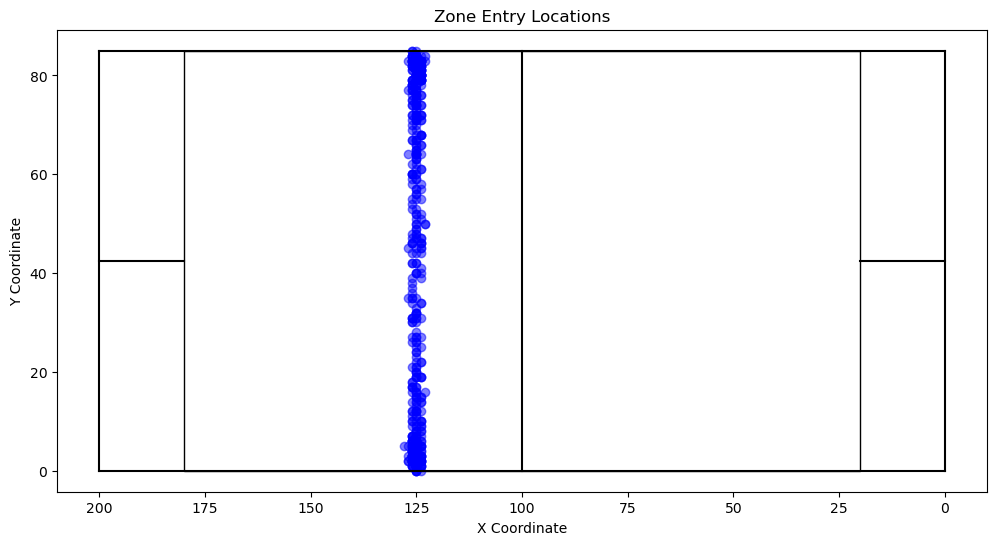

In [5]:
#Function to draw hockey rink
def draw_hockey_rink(ax):
    # Define rink boundaries
    ax.plot([0, 200], [0, 0], color='black')  # End boards
    ax.plot([0, 0], [0, 85], color='black')   # Left boards
    ax.plot([200, 200], [0, 85], color='black')  # Right boards
    ax.plot([0, 200], [85, 85], color='black')  # Goal line
    ax.plot([100, 100], [0, 85], color='black')  # Center line
    ax.plot([0, 20], [42.5, 42.5], color='black')  # Left blue line
    ax.plot([180, 200], [42.5, 42.5], color='black')  # Right blue line
    ax.add_patch(plt.Rectangle((20, 0), 160, 85, edgecolor='black', facecolor='none'))  # Rink area

# Set up the figure
fig, ax = plt.subplots(figsize=(12, 6))

# Draw hockey rink
draw_hockey_rink(ax)

# Plot the zone entries
ax.scatter(zone_entries['X Coordinate'], zone_entries['Y Coordinate'], color='blue', alpha=0.5)

# Title and labels
ax.set_title('Zone Entry Locations')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

# Invert x-axis
ax.invert_xaxis()

plt.show()


From this diagram we can see that most of the zone entries are concentrated at the line x = 125, which is going into the offence zone. To understand why its implications, we will conduct an analysis to determine whether there are specific periods or situations during games where zone entries near x = 125 are more prevalent. Understanding when and why the team employs this strategy can provide valuable insights into their overall game plan.

In [6]:
zone_entries_copy = zone_entries.copy()  # Create a copy of the DataFrame

# Convert 'Clock' column to datetime
zone_entries_copy['Clock'] = pd.to_datetime(zone_entries_copy['Clock'], format='%M:%S')

# Extract minute and second components
zone_entries_copy['Minute'] = zone_entries_copy['Clock'].dt.minute
zone_entries_copy['Second'] = zone_entries_copy['Clock'].dt.second

# Now assign the modified copy back to the original DataFrame
zone_entries = zone_entries_copy
zone_entries

,Date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,...,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2,Minute,Second
13,2023-11-08,Women - United States,Women - Canada,1,1900-01-01 00:19:36,5,5,0,0,Women - Canada,...,6,Carried,NaN,NaN,NaN,Haley Winn,NaN,NaN,19,36
20,2023-11-08,Women - United States,Women - Canada,1,1900-01-01 00:19:23,5,5,0,0,Women - United States,...,52,Dumped,NaN,NaN,NaN,Erin Ambrose,NaN,NaN,19,23
24,2023-11-08,Women - United States,Women - Canada,1,1900-01-01 00:19:18,5,5,0,0,Women - Canada,...,80,Carried,NaN,NaN,NaN,Rory Guilday,NaN,NaN,19,18
39,2023-11-08,Women - United States,Women - Canada,1,1900-01-01 00:18:56,5,5,0,0,Women - United States,...,84,Played,NaN,NaN,NaN,Ashton Bell,NaN,NaN,18,56
43,2023-11-08,Women - United States,Women - Canada,1,1900-01-01 00:18:48,5,5,0,0,Women - Canada,...,63,Carried,NaN,NaN,NaN,Savannah Harmon,NaN,NaN,18,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7427,2023-12-16,Women - Canada,Women - United States,4,1900-01-01 00:01:16,3,3,2,2,Women - United States,...,42,Carried,NaN,NaN,NaN,Jocelyne Larocque,NaN,NaN,1,16
7430,2023-12-16,Women - Canada,Women - United States,4,1900-01-01 00:01:14,3,3,2,2,Women - United States,...,79,Carried,NaN,NaN,NaN,Jocelyne Larocque,NaN,NaN,1,14
7435,2023-12-16,Women - Canada,Women - United States,4,1900-01-01 00:00:58,3,3,2,2,Women - Canada,...,46,Carried,NaN,NaN,NaN,Savannah Harmon,NaN,NaN,0,58
7444,2023-12-16,Women - Canada,Women - United States,4,1900-01-01 00:00:37,3,3,2,2,Women - Canada,...,55,Played,NaN,NaN,NaN,Savannah Harmon,NaN,NaN,0,37


In [7]:
# Grouping the data based on the period and clock time to create intervals for analysis.
temporal_counts = zone_entries.groupby(['Period', 'Minute', 'Second']).size().reset_index(name='Entry Count')
temporal_counts

,Period,Minute,Second,Entry Count
0,1,0,13,1
1,1,0,15,1
2,1,0,17,1
3,1,0,24,3
4,1,0,34,1
...,...,...,...,...
505,4,2,59,1
506,4,3,53,1
507,4,4,16,1
508,4,4,29,1


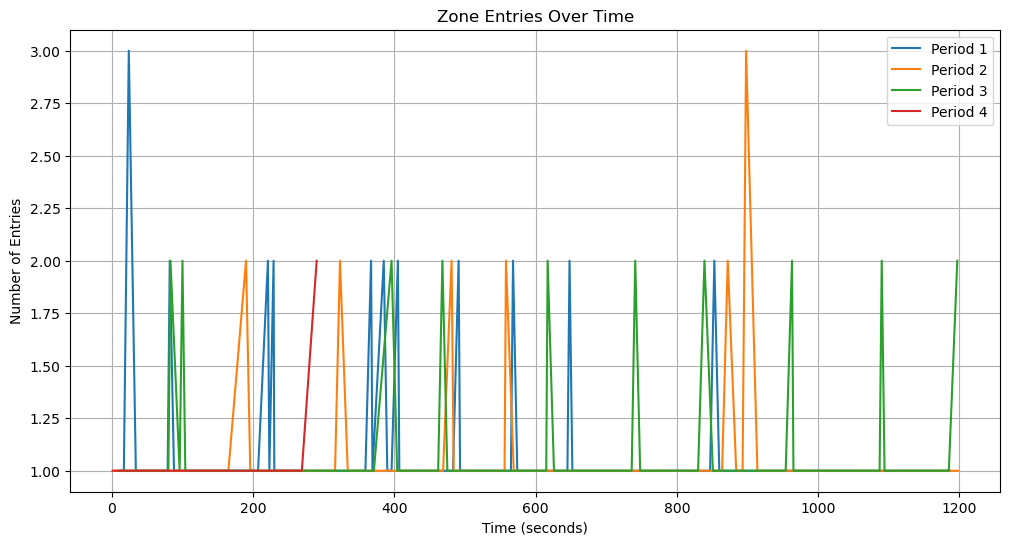

In [8]:
# Line plot
plt.figure(figsize=(12, 6))
for period in temporal_counts['Period'].unique():
    period_data = temporal_counts[temporal_counts['Period'] == period]
    plt.plot(period_data['Minute'] * 60 + period_data['Second'], period_data['Entry Count'], label=f'Period {period}')

plt.title('Zone Entries Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Number of Entries')
plt.legend()
plt.grid(True)
plt.show()

Based on this graph, we notice some interesting things
1) At Period 4, there are only 2 zone entries after the 200-second mark.
2) Period 3 has the most consistent zone entries, there are 2 zone entries for 100 sec, 110 sec, 390 sec, 480 sec, 630 sec, 740 sec, 830 sec, 950 sec, 110 second, and 1180 sec.
3) During period 1, the highest number zone entries happened near the beginning of the period. 
4) During period 2, the highest number of zone entries happened near the 900 sec mark of the period.

# Carried Zone Entries Analysis

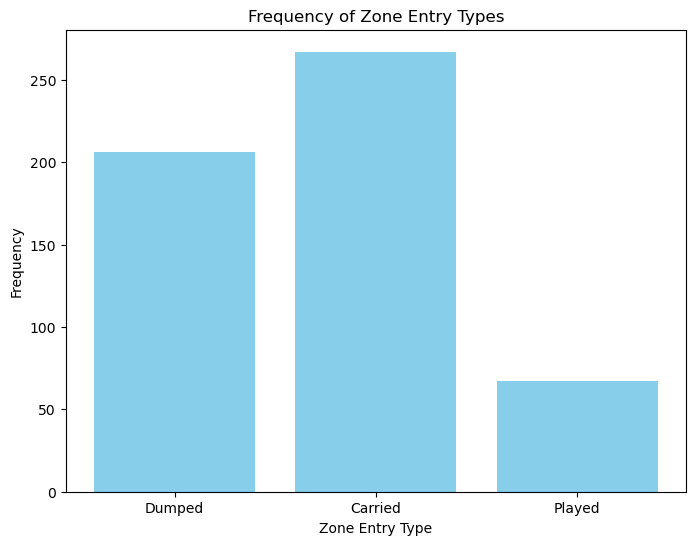

In [9]:
# Count the frequency of each type of zone entry
entry_counts = [len(dumped_entries), len(carried_entries), len(played_entries)]
entry_types = ['Dumped', 'Carried', 'Played']

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(entry_types, entry_counts, color='skyblue')
plt.xlabel('Zone Entry Type')
plt.ylabel('Frequency')
plt.title('Frequency of Zone Entry Types')
plt.show()

From this we can see that the Carried Zone Entry Type is the most frequent among games. Now we are going to analyze in what situations do hockey players carry the puck.

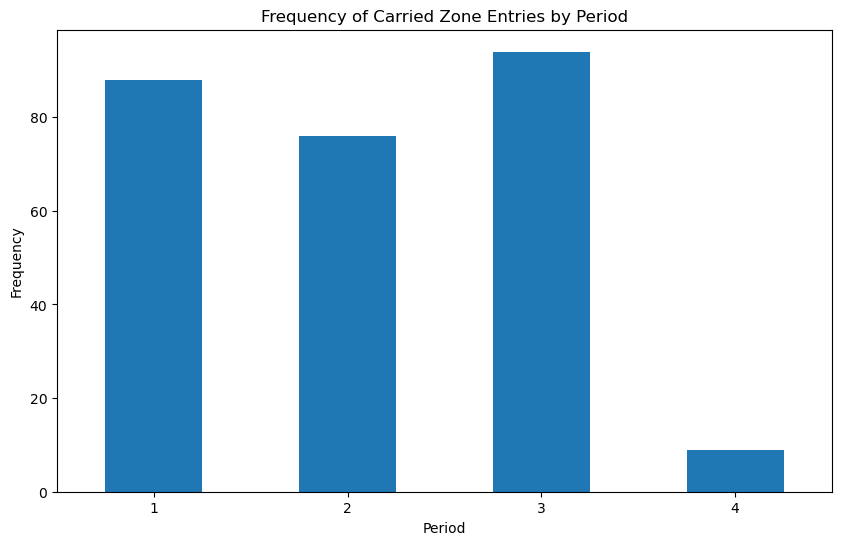

In [10]:
#Groupby the period
grouped_entries = carried_entries.groupby('Period')

#Count the frequency
frequency_counts = grouped_entries.size()

#Create a graph
frequency_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Frequency of Carried Zone Entries by Period')
plt.xlabel('Period')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

Since the most amount of Carried is during Period 3, we will do a temporal analysis to help identify specific moments within Period 3 where carried entries are the most frequent. 

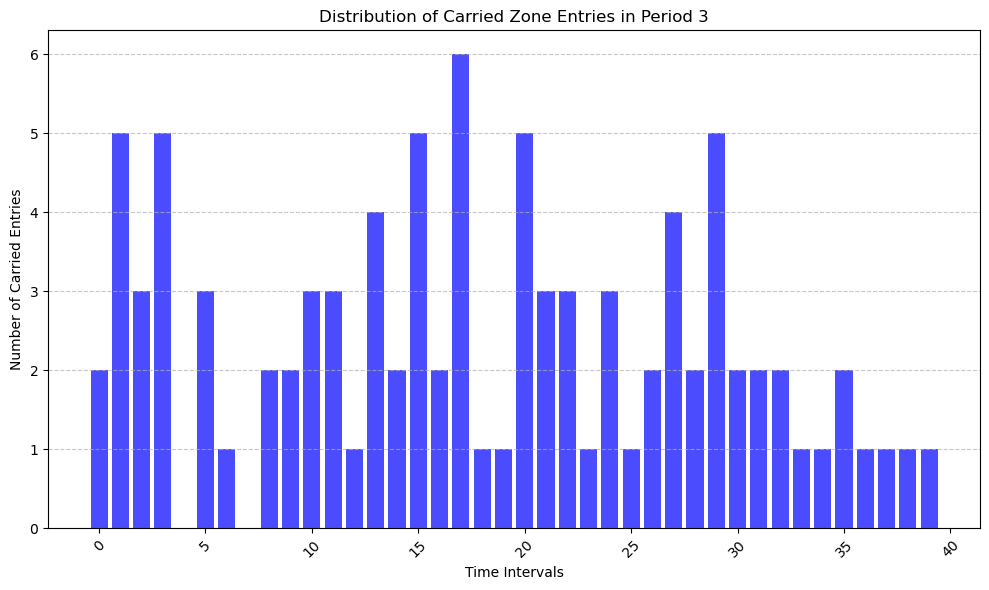

In [11]:
#Filter data to only include Period 3 entries
period_3_entries = df[df['Period'] == 3].copy()


period_3_entries['Clock'] = pd.to_datetime(period_3_entries['Clock'], format='%M:%S', errors='coerce')
interval_seconds = 30
period_3_entries['Time Interval'] = (period_3_entries['Clock'].dt.minute * 60 + period_3_entries['Clock'].dt.second) // interval_seconds

carried_entries_by_interval = period_3_entries[period_3_entries['Detail 1'] == 'Carried'].groupby('Time Interval').size().reset_index(name='Carried Count')

#Plot graph
plt.figure(figsize=(10, 6))
plt.bar(carried_entries_by_interval['Time Interval'], carried_entries_by_interval['Carried Count'], color='blue', alpha=0.7)
plt.title('Distribution of Carried Zone Entries in Period 3')
plt.xlabel('Time Intervals')
plt.ylabel('Number of Carried Entries')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

From this chart, we can see how the most amount of carried entries happens at 17th time interval with a total of 6 carried entries. But in all, there is a higher frequency of carried entries in the middle of the time intervals than at the end. Based on this, we will further examine how the score, period, and time remaining in the game influence the frequency and timing of carried entries.

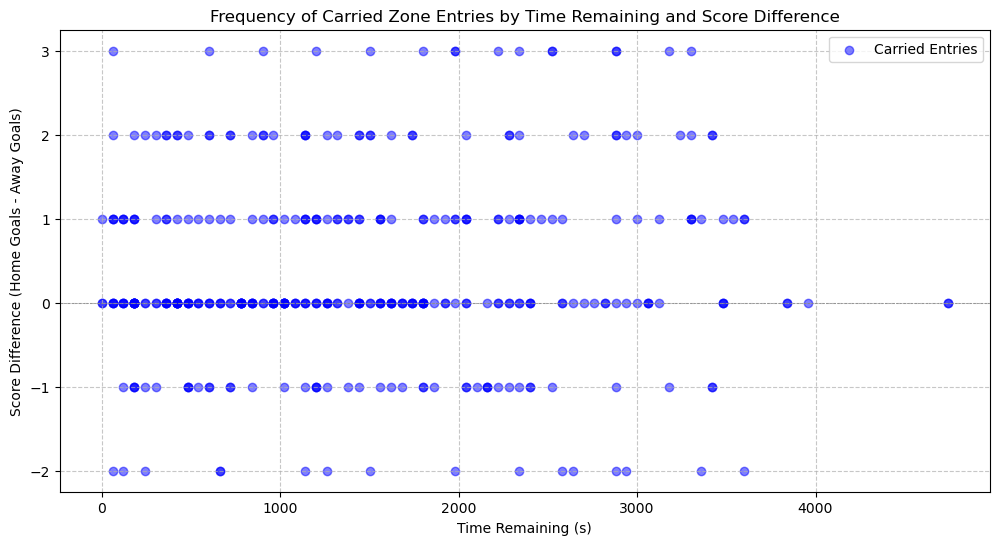

In [19]:
zone_entries_df = zone_entries.copy()
zone_entries_df['Clock'] = pd.to_datetime(zone_entries['Clock'], format='%H:%M:%S')

# Create a new column to represent the time remaining in seconds
zone_entries_df['Time Remaining (s)'] = (zone_entries_df['Period'] * 20 * 60) - (zone_entries_df['Clock'].dt.minute * 60 + zone_entries_df['Clock'].dt.second)

# Filter out entries where time remaining is negative
zone_entries_df = zone_entries_df[zone_entries_df['Time Remaining (s)'] >= 0]

# Plot the frequency of carried zone entries based on the time remaining and score difference
plt.figure(figsize=(12, 6))
plt.scatter(zone_entries_df['Time Remaining (s)'], zone_entries_df['Home Team Goals'] - zone_entries_df['Away Team Goals'], c='blue', alpha=0.5, label='Carried Entries')
plt.xlabel('Time Remaining (s)')
plt.ylabel('Score Difference (Home Goals - Away Goals)')
plt.title('Frequency of Carried Zone Entries by Time Remaining and Score Difference')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)  # Add horizontal line at y=0
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

1. When the score difference is 0, there's a higher frequency of carried entries when there are 3500 seconds or more left.
2. When there is more than 3500 seconds remaining and the score difference is 3, 2, 1, -1, or -2, no carried entries are recorded.
3. Interestingly, when the score difference is -2 or 3, there are carried entries recorded despite the negative score difference.

Investigate correlations between game state variables (e.g., score differences, time remaining) and carried entry frequencies. This can help identify potential relationships between game dynamics and offensive strategies. Scatter plots or correlation matrices can be useful for visualizing these relationships.

In [21]:
print(zone_entries_df.columns)
print(zone_entries_df.head())


Index(['Date', 'Home Team', 'Away Team', 'Period', 'Clock',
       'Home Team Skaters', 'Away Team Skaters', 'Home Team Goals',
       'Away Team Goals', 'Team', 'Player', 'Event', 'X Coordinate',
       'Y Coordinate', 'Detail 1', 'Detail 2', 'Detail 3', 'Detail 4',
       'Player 2', 'X Coordinate 2', 'Y Coordinate 2', 'Time Remaining (s)',
       'Score Differential', 'Score Difference'],
      dtype='object')
           Date              Home Team       Away Team  Period  \
24   2023-11-08  Women - United States  Women - Canada       1   
68   2023-11-08  Women - United States  Women - Canada       1   
92   2023-11-08  Women - United States  Women - Canada       1   
98   2023-11-08  Women - United States  Women - Canada       1   
132  2023-11-08  Women - United States  Women - Canada       1   

                  Clock  Home Team Skaters  Away Team Skaters  \
24  2024-02-28 19:18:00                  5                  5   
68  2024-02-28 18:01:00                  5              

                         Score Differential  Time Remaining (s)  \
Score Differential                 1.000000            0.072280   
Time Remaining (s)                 0.072280            1.000000   
Carried Entry Frequency           -0.143084           -0.347009   

                         Carried Entry Frequency  
Score Differential                     -0.143084  
Time Remaining (s)                     -0.347009  
Carried Entry Frequency                 1.000000  


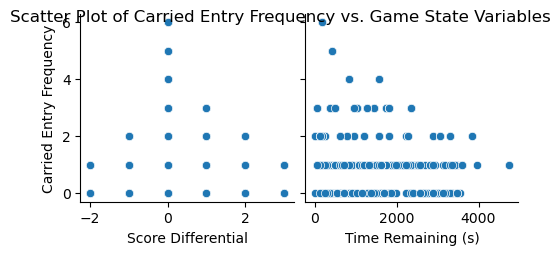

In [28]:
zone_entries_df['Time Remaining (s)'] = (zone_entries_df['Period'] * 20 * 60) - (zone_entries_df['Clock'].dt.minute * 60 + zone_entries_df['Clock'].dt.second)
carried_entries = zone_entries_df[zone_entries_df['Detail 1'] == 'Carried']
carried_entry_frequency = carried_entries.groupby(['Score Differential', 'Time Remaining (s)']).size().reset_index(name='Carried Entry Frequency')

# Merge the carried entry frequency back to the game state variables DataFrame
game_state_variables = pd.merge(zone_entries_df[['Score Differential', 'Time Remaining (s)']], carried_entry_frequency, on=['Score Differential', 'Time Remaining (s)'], how='left')

# Fill missing values with 0 (indicating no carried entries for those game states)
game_state_variables['Carried Entry Frequency'] = game_state_variables['Carried Entry Frequency'].fillna(0)

# Calculate correlation coefficients
correlation_matrix = game_state_variables.corr()
print(correlation_matrix)

# Visualize relationships with scatter plots
sns.pairplot(game_state_variables, x_vars=['Score Differential', 'Time Remaining (s)'], y_vars=['Carried Entry Frequency'], kind='scatter')
plt.suptitle('Scatter Plot of Carried Entry Frequency vs. Game State Variables')
plt.show()


There is a moderate negative correlation between time remaining and carried entry frequency.

In [35]:
# Group carried entry frequencies by score differential and time remaining
grouped_data = game_state_variables.groupby(['Score Differential', 'Time Remaining (s)'])['Carried Entry Frequency'].apply(list)

# Perform ANOVA
f_statistic, p_value = stats.f_oneway(*grouped_data)

# Print results
print("F-Statistic:", f_statistic)
print("P-value:", p_value)

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in carried entry frequencies across different game states.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in carried entry frequencies across different game states.")


F-Statistic: inf
P-value: 0.0
Reject the null hypothesis. There is a significant difference in carried entry frequencies across different game states.


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1. Data Preprocessing
# Assuming X contains features (game state variables) and y contains the target variable (likelihood of a carried entry)
X = game_state_variables[['Score Differential', 'Time Remaining (s)']]
y = game_state_variables['Carried Entry Frequency']  # Assuming this is the target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Choosing a Model
# Logistic Regression
model = LogisticRegression()

# 3. Training the Model
model.fit(X_train, y_train)

# 4. Model Evaluation
# Predict on the testing set
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.3972602739726027
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        17
         1.0       0.41      0.97      0.57        30
         2.0       0.00      0.00      0.00        12
         3.0       0.00      0.00      0.00         9
         4.0       0.00      0.00      0.00         1
         5.0       0.00      0.00      0.00         1
         6.0       0.00      0.00      0.00         3

    accuracy                           0.40        73
   macro avg       0.06      0.14      0.08        73
weighted avg       0.17      0.40      0.24        73



/Users/rishika/anaconda3/envs/BigDataCup/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rishika/anaconda3/envs/BigDataCup/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rishika/anaconda3/envs/BigDataCup/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: Undefi

Accuracy: 0.397, indicating that approximately 39.7% of the predictions made by the model are correct.
Precision: Precision measures the accuracy of the positive predictions made by the model. For class 1.0 (carried entry occurrence), the precision is 0.41. This means that out of all instances predicted as carried entry occurrences, only 41% are correct.
Recall: Recall measures the ability of the model to correctly identify all positive instances. For class 1.0, the recall is 0.97, indicating that the model can correctly identify 97% of the actual carried entry occurrences.
F1-score: The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall. For class 1.0, the F1-score is 0.57.
Support: The number of actual occurrences of each class in the test data.
Overall, the model seems to have relatively high recall but low precision, indicating that it tends to capture most carried entry occurrences but also makes a significant number of false positive predictions. The overall accuracy is also relatively low, suggesting that the model's performance may vary across different classes or that the data might be imbalanced. Further analysis and potential model improvements may be needed to enhance the predictive performance.

# Insignificant Results

Now we will try to see if 

In [ ]:
# Convert 'Clock' column to numerical values
df['Clock'] = pd.to_numeric(df['Clock'], errors='coerce')

# Define success criteria (e.g., shot on goal within 10 seconds of entry)

success_criteria = (df['Event'] == 'Shot') & (df['Detail 1'] == 'On Net') & (df['Clock'] <= 10)

# Filter the dataset to include only zone entries and subsequent successful events
successful_entries = df[(df['Event'] == 'Zone Entry') & success_criteria]

# Calculate total number of zone entries
total_entries = len(df[df['Event'] == 'Zone Entry'])

# Calculate success rate
success_rate = (len(successful_entries) / total_entries) * 100

print(f"Total Zone Entries: {total_entries}")
print(f"Successful Entries: {len(successful_entries)}")
print(f"Success Rate: {success_rate:.2f}%")

In [ ]:
#Since the criteria for 10 seconds of entry lead to a 0% success rate, we will broaden the success criteria to 60 seconds of entry.
# Convert 'Clock' column to numerical values
df['Clock'] = pd.to_numeric(df['Clock'], errors='coerce')

# Define success criteria (e.g., shot on goal within 10 seconds of entry)

success_criteria = (df['Event'] == 'Shot') & (df['Detail 1'] == 'On Net') & (df['Clock'] <= 60)

# Filter the dataset to include only zone entries and subsequent successful events
successful_entries = df[(df['Event'] == 'Zone Entry') & success_criteria]

# Calculate total number of zone entries
total_entries = len(df[df['Event'] == 'Zone Entry'])

# Calculate success rate
success_rate = (len(successful_entries) / total_entries) * 100

print(f"Total Zone Entries: {total_entries}")
print(f"Successful Entries: {len(successful_entries)}")
print(f"Success Rate: {success_rate:.2f}%")

Even after changing the success criteria from 10 seconds to 60 seconds, the success rate is still at 0%. This suggests that none of the xone entries are leading to goals. Instead of focusing on a success being a goal being shot in 60 seconds, we will change the criteria to include the positive events from a zone entry.   

In [ ]:
# Define revised success criteria
revised_success_criteria = ((df['Event'] == 'Shot')  & (df['Clock'] <= 60)) | \
                           (df['Event'] == 'Goal') | \
                           (df['Event'] == 'Takeaway') | \
                           ((df['Event'] == 'Play') | \
                           (df['Event'] == 'Dump In/Out'))

# Filter the dataset to include only zone entries and subsequent successful events
successful_entries = df[((df['Event'] == 'Zone Entry') & revised_success_criteria)]

# Calculate total number of zone entries
total_entries = len(df[df['Event'] == 'Zone Entry'])

# Calculate success rate
success_rate = (len(successful_entries) / total_entries) * 100

print(f"Total Zone Entries: {total_entries}")
print(f"Successful Entries: {len(successful_entries)}")
print(f"Success Rate: {success_rate:.2f}%")

Even after revising the success criteria to involve positive outcomes from a zone entry, we still get a 0% success rate, it's possible that there are no events in your dataset that meet the criteria for success after a zone entry. Because of this, we will move onto looking at the number of carried/dumped entries to see which strategy is more frequently utilized.

In [ ]:
# Count the number of entries for each method
count_dumped = len(dumped_entries)
count_carried = len(carried_entries)

# Print the counts
print(f"Number of 'Dumped' entries: {count_dumped}")
print(f"Number of 'Carried' entries: {count_carried}")

# Compare the frequency of entry methods
if count_dumped > count_carried:
    print("There are more 'Dumped' entries.")
elif count_dumped < count_carried:
    print("There are more 'Carried' entries.")
else:
    print("The frequency of 'Dumped' and 'Carried' entries is the same.")


In [ ]:
# Function to calculate possession retention
def calculate_possession_retention(entries):
    # Assuming possession retention is defined as maintaining control for at least 10 seconds
    retention_criteria = entries['Clock'] <= (entries['Clock'].min() + 10)
    possession_retention_rate = (retention_criteria.sum() / len(entries)) * 100
    return possession_retention_rate

# Calculate possession retention for dumped and carried entries
possession_retention_dumped = calculate_possession_retention(dumped_entries)
possession_retention_carried = calculate_possession_retention(carried_entries)

# Display the results
print("Possession Retention:")
print("Dumped Entries: " + str(possession_retention_dumped))
print("Carried Entries: " + str(possession_retention_carried))